In [92]:
import re
import numpy as np
import pandas as pd
import seaborn as sb
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords

import spacy
import emoji
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Reshape, Flatten, concatenate, Input, GlobalMaxPooling1D, GlobalMaxPool1D, Activation
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, roc_auc_score, auc, classification_report, \
                                recall_score, precision_recall_curve, precision_score, mean_squared_error, \
                                log_loss, accuracy_score

stop = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
# df1 = pd.read_csv('test.csv')
# df2 = pd.read_csv('tes1.csv')
data = pd.read_csv('kaggle_plus_our_data.csv')
data

,tweet_id,sentiment,tweet_text
0,1.387628e+18,3,Please when offered a vaccine don't wait for o...
1,1.392383e+18,3,"RT @aminamnzr: ""High- and upper-middle income ..."
2,1.392313e+18,2,"2) Starting May 24, Lyft will begin providing ..."
3,1.392235e+18,1,RT @g10dc: @BSimonward Who the heck (unless ex...
4,1.391884e+18,3,RT @Health4AllAmer: Today found out husband of...
...,...,...,...
8562,1.500000e+18,1,People have stopped taking it after reading ab...
8563,1.500000e+18,3,Loughborough Hospital have a Covid-19 walk-in ...
8564,1.500000e+18,2,It's a clone this one Nkosi yam If it knows ab...
8565,1.500000e+18,1,Massachusetts pharma company sues Moderna and ...


In [93]:
# Preprocessing main function

# Punction and Numbers remove
def punc_clean(text):
    
    text= ' '.join(re.sub('(@[A-Za-z0-9_]+)|(&[A-Za-z0-9_]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)' , " ", text).split())
    text = re.sub('[0-9]+', '', text)
    text = re.sub('['+string.punctuation+']', '', text)
    return text

# Remove emoji function
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Convert these @pfizer, @sinovac, @moderna_tx, @sputnikvaccine to normal form pfizer/sinovac/moderna/sputnik
def replace_name(data): 
    
    vaccine_dict = {"@pfizer": "pfizer",
                    "@sinovac": "sinovac",
                   "@moderna_tx": "moderna",
                   "@sputnikvaccine": "sputnik"}

    for index,values in enumerate(data['tweet_text']):
        if "@pfizer" in values:
            vaccine_name = "@pfizer"
            replace_name = vaccine_dict[vaccine_name]
            data.loc[index, 'tweet_text'] = data.loc[index, 'tweet_text'].replace(vaccine_name, replace_name)

        if "@sinovac" in values:
            vaccine_name = "@sinovac"
            replace_name = vaccine_dict[vaccine_name]
            data.loc[index, 'tweet_text'] = data.loc[index, 'tweet_text'].replace(vaccine_name, replace_name)

        if "@moderna_tx" in values:
            vaccine_name = "@moderna_tx"
            replace_name = vaccine_dict[vaccine_name]
            data.loc[index, 'tweet_text'] = data.loc[index, 'tweet_text'].replace(vaccine_name, replace_name)

        if "@sputnikvaccine" in values:
            vaccine_name = "@sputnikvaccine"
            replace_name = vaccine_dict[vaccine_name]
            data.loc[index, 'tweet_text'] = data.loc[index, 'tweet_text'].replace(vaccine_name, replace_name)
            
    return data

# Lemmatization on text using Spacy tools
def space(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# Another alternative if you dont like lemmatizion
def stemming(text):
    porter = PorterStemmer()
    words = text.split() 
    stemmed_words = [porter.stem(word) for word in words]
    return " ".join(stemmed_words)

# Remove stopwards aka common wors from the text, but varies from dataset
def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no", "don't", "cannot"]
    words = text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
# Main preprocess function
def preprocess(data):
#     path = os.path.join(path)
#     data = pd.read_csv(path)
    
    data = replace_name(data)
    
    data['cleaned_text'] = data['tweet_text'].apply(lambda x:x.lower())
    data['cleaned_text'] = data['cleaned_text'].apply(lambda x:emoji.demojize(x))
    #data['cleaned_text'] = data['cleaned_text'].apply(remove_stopwords)
    data['cleaned_text'] = data['cleaned_text'].str.encode('ascii', 'ignore').str.decode('ascii')
    data['cleaned_text'] = data['cleaned_text'].apply(space)
    #data['cleaned_text'] = data['cleaned_text'].apply(lambda x:remove_emoji(x))
    data['cleaned_text'] = data['cleaned_text'].apply(punc_clean)
    
    has_duplicate = data.duplicated(subset=['cleaned_text']).any()
    if has_duplicate:
        data.drop_duplicates(subset=['cleaned_text'], inplace=True)
        
    return data

In [94]:
cleaned_data = preprocess(data)
cleaned_data

,tweet_id,sentiment,tweet_text,cleaned_text
0,1.387628e+18,3,Please when offered a vaccine don't wait for o...,please when offer a vaccine do not wait for on...
1,1.392383e+18,3,"RT @aminamnzr: ""High- and upper-middle income ...",rt high and upper middle income country repres...
2,1.392313e+18,2,"2) Starting May 24, Lyft will begin providing ...",start may lyft will begin provide ride code ...
3,1.392235e+18,1,RT @g10dc: @BSimonward Who the heck (unless ex...,rt who the heck unless extremely vulnerable wo...
4,1.391884e+18,3,RT @Health4AllAmer: Today found out husband of...,rt today find out husband of a staff member at...
...,...,...,...,...
8562,1.500000e+18,1,People have stopped taking it after reading ab...,people have stop take it after read about the ...
8563,1.500000e+18,3,Loughborough Hospital have a Covid-19 walk-in ...,loughborough hospital have a covid walk in vac...
8564,1.500000e+18,2,It's a clone this one Nkosi yam If it knows ab...,it be a clone this one nkosi yam if it know ab...
8565,1.500000e+18,1,Massachusetts pharma company sues Moderna and ...,massachusetts pharma company sue moderna and p...


In [95]:
X = cleaned_data['cleaned_text']
X

0       please when offer a vaccine do not wait for on...
1       rt high and upper middle income country repres...
2        start may  lyft will begin provide ride code ...
3       rt who the heck unless extremely vulnerable wo...
4       rt today find out husband of a staff member at...
                              ...                        
8562    people have stop take it after read about the ...
8563    loughborough hospital have a covid walk in vac...
8564    it be a clone this one nkosi yam if it know ab...
8565    massachusetts pharma company sue moderna and p...
8566                    now add pfizer and moderna please
Name: cleaned_text, Length: 8306, dtype: object

In [96]:
# Convert labels (sentiment) to one-hot encode so that to be able to use Categorical_crossentrophy
y = pd.get_dummies(cleaned_data['sentiment']).values
y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]], dtype=uint8)

In [97]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in cleaned_data.cleaned_text]
tokens

[['please',
  'when',
  'offer',
  'a',
  'vaccine',
  'do',
  'not',
  'wait',
  'for',
  'one',
  'or',
  'the',
  'other',
  'they',
  'be',
  'all',
  'safe',
  'the',
  'good',
  'vaccine',
  'be',
  'the',
  'one',
  'that',
  'g'],
 ['rt',
  'high',
  'and',
  'upper',
  'middle',
  'income',
  'country',
  'represent',
  'of',
  'the',
  'world',
  'population',
  'but',
  'have',
  'receive',
  'of',
  'the',
  'worlds',
  'vacci'],
 ['start',
  'may',
  'lyft',
  'will',
  'begin',
  'provide',
  'ride',
  'code',
  'that',
  'cover',
  'up',
  'to',
  'of',
  'each',
  'trip',
  'to',
  'and',
  'from',
  'a',
  'vaccinatio'],
 ['rt',
  'who',
  'the',
  'heck',
  'unless',
  'extremely',
  'vulnerable',
  'would',
  'take',
  'a',
  'drug',
  'still',
  'in',
  'trial',
  'stage',
  'that',
  'have',
  'an',
  'absolute',
  'risk',
  'reduct'],
 ['rt',
  'today',
  'find',
  'out',
  'husband',
  'of',
  'a',
  'staff',
  'member',
  'at',
  'our',
  'school',
  'got',
  'c

In [98]:
# Create your own word2vec using gensim
from gensim.models import KeyedVectors, Word2Vec
# embed_dim = 200
# vocabSize = train_word_index+1
# word2vec_model = Word2Vec(tokens,
#                  vector_size=embed_dim,
#                  workers=8,
#                  min_count=3,
#                  window=5)
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 2

# print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

word2vec_model = Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

In [99]:
word2vec_model.build_vocab(tokens)

In [100]:
word2vec_model.train(tokens, total_examples=len(tokens), epochs=32)

(4480035, 6296256)

In [101]:
word2vec_model.wv.most_similar("sinovac")

[('sinopharm', 0.7358090281486511),
 ('kong', 0.6549501419067383),
 ('hong', 0.6043755412101746),
 ('chinese', 0.5976647734642029),
 ('uae', 0.549689769744873),
 ('china', 0.5194382071495056),
 ('omicron', 0.5161755084991455),
 ('coronavac', 0.5106339454650879),
 ('paf', 0.5060634613037109),
 ('hongkong', 0.5057591795921326)]

In [102]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_data.cleaned_text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 14245


In [103]:
# Split the datasets to train/test/validation
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [104]:
# Pad the sequences to make all the same == maxlength
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=50)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=50)

In [105]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
print(embedding_matrix.shape)

(14245, 300)


In [106]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=50, trainable=False)

In [110]:
# Using LSTM 
LSTM_model = Sequential()
LSTM_model.add(embedding_layer)
LSTM_model.add(Dropout(0.5))
LSTM_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
LSTM_model.add(Dense(3, activation='softmax'))
LSTM_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
# Using Bi-directional
BI_LSTM_model = Sequential()
BI_LSTM_model.add(embedding_layer)
BI_LSTM_model.add(Dropout(0.3))
BI_LSTM_model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
BI_LSTM_model.add(Dense(3,activation='softmax'))
BI_LSTM_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [112]:
# Using CNN 
tweet_input = Input(shape=(50,), dtype='int32')

tweet_encoder = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=50, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
bigram_branch = Dropout(0.2)(bigram_branch)
trigram_branch = Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
trigram_branch = Dropout(0.2)(trigram_branch)

fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
fourgram_branch = Dropout(0.2)(trigram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(3)(merged)
output = Activation('softmax')(merged)
CNN_model = Model(inputs=[tweet_input], outputs=[output])

CNN_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
CNN_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 50, 300)      4273500     ['input_4[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 48, 64)       57664       ['embedding_5[0][0]']            
                                                                                                  
 conv1d_11 (Conv1D)             (None, 49, 64)       38464       ['embedding_5[0][0]']            
                                                                                            

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [113]:
history = LSTM_model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/5
187/187 [==============================] - 25s 123ms/step - loss: 0.8536 - accuracy: 0.6066 - val_loss: 0.8588 - val_accuracy: 0.6195 - lr: 0.0010
Epoch 2/5
187/187 [==============================] - 22s 117ms/step - loss: 0.7819 - accuracy: 0.6454 - val_loss: 0.9048 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 3/5
187/187 [==============================] - 22s 117ms/step - loss: 0.7469 - accuracy: 0.6650 - val_loss: 0.8479 - val_accuracy: 0.6165 - lr: 0.0010
Epoch 4/5
187/187 [==============================] - 22s 115ms/step - loss: 0.7284 - accuracy: 0.6764 - val_loss: 0.8903 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 5/5
187/187 [==============================] - 25s 134ms/step - loss: 0.7039 - accuracy: 0.6859 - val_loss: 0.8767 - val_accuracy: 0.6211 - lr: 0.0010


In [114]:
history = BI_LSTM_model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/5
187/187 [==============================] - 53s 236ms/step - loss: 0.8314 - accuracy: 0.6267 - val_loss: 0.8619 - val_accuracy: 0.6105 - lr: 0.0010
Epoch 2/5
187/187 [==============================] - 43s 230ms/step - loss: 0.7568 - accuracy: 0.6526 - val_loss: 0.8265 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 3/5
187/187 [==============================] - 42s 227ms/step - loss: 0.7189 - accuracy: 0.6799 - val_loss: 0.8613 - val_accuracy: 0.6165 - lr: 0.0010
Epoch 4/5
187/187 [==============================] - 50s 267ms/step - loss: 0.6860 - accuracy: 0.6994 - val_loss: 0.8529 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 5/5
187/187 [==============================] - 46s 244ms/step - loss: 0.6460 - accuracy: 0.7103 - val_loss: 0.8612 - val_accuracy: 0.6135 - lr: 0.0010


In [115]:
history = CNN_model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/5
187/187 [==============================] - 18s 90ms/step - loss: 0.9455 - accuracy: 0.5804 - val_loss: 0.8437 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 2/5
187/187 [==============================] - 15s 83ms/step - loss: 0.7905 - accuracy: 0.6461 - val_loss: 0.8407 - val_accuracy: 0.6105 - lr: 0.0010
Epoch 3/5
187/187 [==============================] - 14s 75ms/step - loss: 0.7333 - accuracy: 0.6677 - val_loss: 0.8022 - val_accuracy: 0.6165 - lr: 0.0010
Epoch 4/5
187/187 [==============================] - 13s 71ms/step - loss: 0.6658 - accuracy: 0.7073 - val_loss: 0.8194 - val_accuracy: 0.6376 - lr: 0.0010
Epoch 5/5
187/187 [==============================] - 14s 77ms/step - loss: 0.6073 - accuracy: 0.7369 - val_loss: 0.8535 - val_accuracy: 0.6105 - lr: 0.0010


In [116]:
def get_true_pred(predictions, y_test):
    neg_count, neu_count, pos_count = 0, 0, 0
    real_neg, real_neu, real_pos = 0, 0, 0

    y_pred = []
    y_true = []

    for i, prediction in enumerate(predictions):
        if np.argmax(prediction) == 0:
            neg_count += 1
        elif np.argmax(prediction) == 1:
            neu_count += 1
        else:
            pos_count += 1

        y_pred.append(np.argmax(prediction))

        if np.argmax(y_test[i]) == 0:
            real_neg += 1
        elif np.argmax(y_test[i]) == 1:    
            real_neu += 1
        else:
            real_pos +=1

        y_true.append(np.argmax(y_test[i]))

    print('Negative predictions:', neg_count)
    print('Neutral predictions:', neu_count)
    print('Positive predictions:', pos_count)
    print('True negative:', real_neg)
    print('True neutral:', real_neu)
    print('True positive:', real_pos)
    
    return y_true, y_pred

In [117]:
def Confusion_Matrix(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted: 1','Predicted: 2','Predicted: 3'],
                                         index=['Actual: 1','Actual: 2','Actual: 3'])
                                                        
    plt.figure(figsize = (10,5))
    sb.set(font_scale=1.2)
    sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    plt.title("Confusion Matrix for Sentiment Analysis using RNN")
    plt.yticks(rotation=360)
    plt.show()

    print("Confusion Matrix for Sentiment Analysis using RNN:",accuracy_score(y_true, y_pred))
    print("-"*100)
    print("Classification Report for Sentiment Analysis using RNN:\n\n",classification_report(y_true, y_pred))
    print("-"*100)
    Negative = cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2])*100
    print("Negative has a accuracy of {} %".format(Negative))
    print()
    Neutral = cm[1][1]/(cm[1][1]+cm[1][0]+cm[1][2])*100
    print("Neutral has a accuracy of {} %".format(Neutral))
    print()
    Positive = cm[2][2]/(cm[2][2]+cm[2][0]+cm[2][1])*100
    print("Positive has a accuracy of {} %".format(Positive))

Negative predictions: 67
Neutral predictions: 1164
Positive predictions: 431
True negative: 235
True neutral: 935
True positive: 492


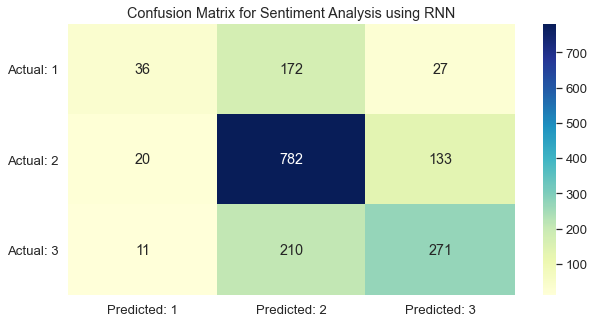

Confusion Matrix for Sentiment Analysis using RNN: 0.6552346570397112
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using RNN:

               precision    recall  f1-score   support

           0       0.54      0.15      0.24       235
           1       0.67      0.84      0.75       935
           2       0.63      0.55      0.59       492

    accuracy                           0.66      1662
   macro avg       0.61      0.51      0.52      1662
weighted avg       0.64      0.66      0.63      1662

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 15.319148936170212 %

Neutral has a accuracy of 83.63636363636363 %

Positive has a accuracy of 55.08130081300813 %


In [118]:
pred = LSTM_model.predict(x_test)
y_true, y_pred = get_true_pred(pred, y_test)
Confusion_Matrix(y_true, y_pred)

Negative predictions: 166
Neutral predictions: 1020
Positive predictions: 476
True negative: 235
True neutral: 935
True positive: 492


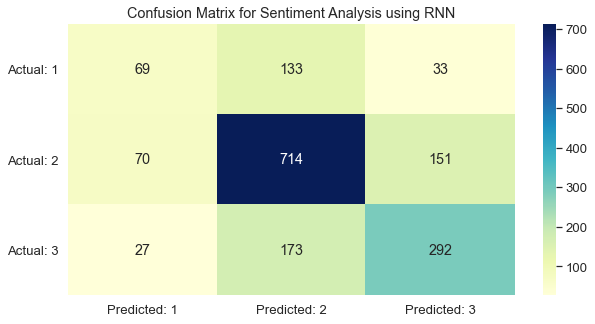

Confusion Matrix for Sentiment Analysis using RNN: 0.6468110709987966
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using RNN:

               precision    recall  f1-score   support

           0       0.42      0.29      0.34       235
           1       0.70      0.76      0.73       935
           2       0.61      0.59      0.60       492

    accuracy                           0.65      1662
   macro avg       0.58      0.55      0.56      1662
weighted avg       0.63      0.65      0.64      1662

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 29.361702127659573 %

Neutral has a accuracy of 76.36363636363637 %

Positive has a accuracy of 59.34959349593496 %


In [119]:
pred = BI_LSTM_model.predict(x_test)
y_true, y_pred = get_true_pred(pred, y_test)
Confusion_Matrix(y_true, y_pred)

Negative predictions: 148
Neutral predictions: 846
Positive predictions: 668
True negative: 235
True neutral: 935
True positive: 492


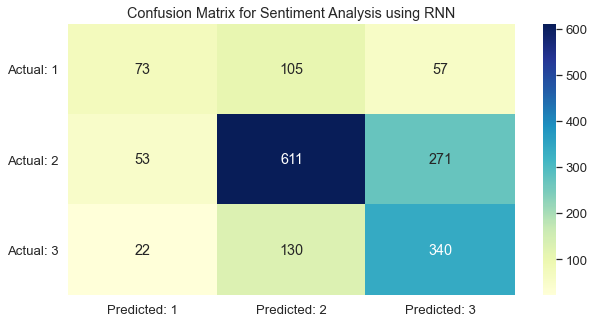

Confusion Matrix for Sentiment Analysis using RNN: 0.6161251504211793
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using RNN:

               precision    recall  f1-score   support

           0       0.49      0.31      0.38       235
           1       0.72      0.65      0.69       935
           2       0.51      0.69      0.59       492

    accuracy                           0.62      1662
   macro avg       0.57      0.55      0.55      1662
weighted avg       0.63      0.62      0.61      1662

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 31.06382978723404 %

Neutral has a accuracy of 65.3475935828877 %

Positive has a accuracy of 69.10569105691057 %


In [120]:
pred = CNN_model.predict(x_test)
y_true, y_pred = get_true_pred(pred, y_test)
Confusion_Matrix(y_true, y_pred)

## Testing it on Randomly_Sampled 1

In [121]:
test_data = pd.read_csv('randomly_sample_01.csv')
test_data['sentiment'].value_counts()

NEUTRAL     475
NEGATIVE    391
POSITIVE    163
Name: sentiment, dtype: int64

In [122]:
test_data = test_data[['text', 'sentiment']]
test_data = test_data.rename(columns={'text': 'tweet_text'})
test_data

,tweet_text,sentiment
0,I just love this Moderna is next Promise,POSITIVE
1,DOH Filipinos hesitant to get Sputnik V COVID-...,NEUTRAL
2,So glad I didn't get the injections,NEGATIVE
3,Edward Dowd Explains Bombshell ‘Fraud Charge r...,NEUTRAL
4,And I love it when the British Medical Journal...,NEGATIVE
...,...,...
1024,Or 🇭 have Sinovac VAED Or both I have faith se...,NEGATIVE
1025,More people with 3 doses of the vaccine curren...,NEGATIVE
1026,pfizer Pharma owns the journals They massage s...,NEGATIVE
1027,pfizer He's in bed with BIG pharma getting mil...,NEGATIVE


In [123]:
for index, value in enumerate(test_data['sentiment']):
    if value == 'POSITIVE':
        test_data.loc[index, 'sentiment'] = 3
    elif value == 'NEUTRAL':
        test_data.loc[index, 'sentiment'] = 2
    else:
        test_data.loc[index, 'sentiment'] = 1
test_data

,tweet_text,sentiment
0,I just love this Moderna is next Promise,3
1,DOH Filipinos hesitant to get Sputnik V COVID-...,2
2,So glad I didn't get the injections,1
3,Edward Dowd Explains Bombshell ‘Fraud Charge r...,2
4,And I love it when the British Medical Journal...,1
...,...,...
1024,Or 🇭 have Sinovac VAED Or both I have faith se...,1
1025,More people with 3 doses of the vaccine curren...,1
1026,pfizer Pharma owns the journals They massage s...,1
1027,pfizer He's in bed with BIG pharma getting mil...,1


In [124]:
test_cleaned = preprocess(test_data)
test_cleaned

,tweet_text,sentiment,cleaned_text
0,I just love this Moderna is next Promise,3,I just love this moderna be next promise
1,DOH Filipinos hesitant to get Sputnik V COVID-...,2,doh filipino hesitant to get sputnik v covid j...
2,So glad I didn't get the injections,1,so glad I do not get the injection
3,Edward Dowd Explains Bombshell ‘Fraud Charge r...,2,edward dowd explain bombshell fraud charge re ...
4,And I love it when the British Medical Journal...,1,and I love it when the british medical journal...
...,...,...,...
1024,Or 🇭 have Sinovac VAED Or both I have faith se...,1,or have sinovac vaed or both I have faith seve...
1025,More people with 3 doses of the vaccine curren...,1,more people with dose of the vaccine currentl...
1026,pfizer Pharma owns the journals They massage s...,1,pfizer pharma own the journal they massage sta...
1027,pfizer He's in bed with BIG pharma getting mil...,1,pfizer he be in bed with big pharma get millio...


In [125]:
test_cleaned = test_cleaned[['cleaned_text', 'sentiment']]
test_cleaned

,cleaned_text,sentiment
0,I just love this moderna be next promise,3
1,doh filipino hesitant to get sputnik v covid j...,2
2,so glad I do not get the injection,1
3,edward dowd explain bombshell fraud charge re ...,2
4,and I love it when the british medical journal...,1
...,...,...
1024,or have sinovac vaed or both I have faith seve...,1
1025,more people with dose of the vaccine currentl...,1
1026,pfizer pharma own the journal they massage sta...,1
1027,pfizer he be in bed with big pharma get millio...,1


In [126]:
sequences_test = tokenizer.texts_to_sequences(test_cleaned['cleaned_text'])
x_test = pad_sequences(sequences_test, maxlen=50)
x_test

array([[   0,    0,    0, ...,    2,  215,  936],
       [   0,    0,    0, ...,    4,  493,  417],
       [   0,    0,    0, ...,   16,    1,  317],
       ...,
       [   0,    0,    0, ..., 1527, 4339,   58],
       [   0,    0,    0, ...,  996,  105,   25],
       [   0,    0,    0, ...,    1,  481,  165]])

In [127]:
y_test = pd.get_dummies(test_cleaned['sentiment']).values
y_test

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

Negative predictions: 316
Neutral predictions: 571
Positive predictions: 142
True negative: 391
True neutral: 475
True positive: 163


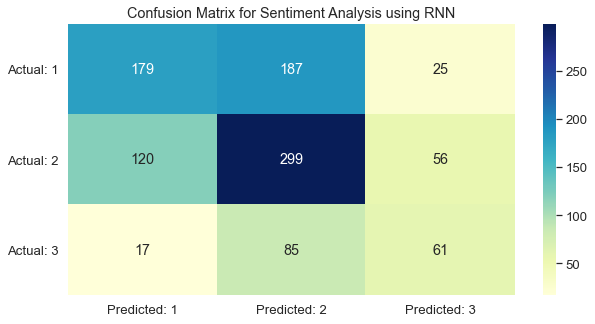

Confusion Matrix for Sentiment Analysis using RNN: 0.5238095238095238
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using RNN:

               precision    recall  f1-score   support

           0       0.57      0.46      0.51       391
           1       0.52      0.63      0.57       475
           2       0.43      0.37      0.40       163

    accuracy                           0.52      1029
   macro avg       0.51      0.49      0.49      1029
weighted avg       0.53      0.52      0.52      1029

----------------------------------------------------------------------------------------------------
Negative has a accuracy of 45.78005115089514 %

Neutral has a accuracy of 62.94736842105263 %

Positive has a accuracy of 37.423312883435585 %


In [138]:
pred = BI_LSTM_model.predict(x_test)
y_true, y_pred = get_true_pred(pred, y_test)
Confusion_Matrix(y_true, y_pred)

### One reason the prediction is not good on the test set is because, I think some of the sentiment labelling by people, is not accurate.

## Trying it on random Text, to see how good it predict

In [132]:
# Saving Tokenizer so that in the future we can continue to use
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [155]:
import keras
load_model = keras.models.load_model('best_model_1.h5')

# This function is used to predict any text, so long as model and tokenizer is present
def predict_sentiment(text, token, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(token.texts_to_sequences([text]), maxlen=50)
    
    # Predict
    score = load_model.predict([x_test])[0]
    print(score)
    sentiment = np.argmax(score)
    if sentiment == 0:
        return "NEGATIVE"
    if sentiment == 1:
        return "NEUTRAL"
    if sentiment == 2:
        return "POSITIVE"
    
    return sentiment 

In [156]:
predict_sentiment('fuck you', tokenizer)

[0.5214235  0.33668315 0.14189331]


'NEGATIVE'

In [157]:
predict_sentiment('happy birthday', tokenizer)

[0.01223611 0.06297791 0.924786  ]


'POSITIVE'

In [158]:
predict_sentiment('good job pfizer', tokenizer)

[0.12402993 0.31400073 0.5619693 ]


'POSITIVE'

In [159]:
predict_sentiment('bad job pfizer', tokenizer)

[0.42407325 0.30364746 0.27227935]


'NEGATIVE'